In [1]:
import torch
from rim import RIMNetwork, RIMNetwork_specialized,RIMNetwork_specialized_multHead, RIMNetwork_multHead
import yaml
import pprint
import numpy as np
import matplotlib.pyplot as plt
from Mod_Cog.mod_cog_tasks import *
from neurogym import Dataset

import matplotlib.font_manager
from matplotlib import rcParams
rcParams['font.sans-serif'] = "ubuntu"
rcParams['font.family'] = "ubuntu"



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compress_labels(labels):
    new_labels = np.zeros_like(labels)
    for i in range(labels.shape[0]):
        prev_val = 0
        for j in range(labels.shape[1]):
            curr_val = labels[i,j]
            if curr_val != 0 and curr_val == prev_val:
                new_labels[i,j] = 0
            else:
                new_labels[i,j] = curr_val
            prev_val = curr_val
    return new_labels

/home/felix/Documents/phd/.venv/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [2]:
'''
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), dlydm1(), dlydm2(),
                ctxdlydm1(), ctxdlydm2(), multidlydm(), dms(), dnms(), dmc(), dnmc()]

envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti',
                'dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 'dlydm1', 'dlydm2',
                'ctxdlydm1', 'ctxdlydm2', 'multidlydm', 'dms', 'dnms', 'dmc', 'dnmc']

'''
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),dm1(), dm2()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti','dm1', 'dm2']


In [3]:
# name of the model to analyze
name = "model_rim_12_mono"

# import parameters
params_path = "saved_models/"+name+".yaml"
with open(params_path) as file:
            parameters = yaml.load(file, Loader=yaml.FullLoader)
pprint.pprint(parameters)

# loading the model we want to analyze
model = RIMNetwork_multHead(input_size=parameters["input_size"], hidden_size=parameters["hidden_size"], 
                    output_size=parameters["output_size"], num_mechanisms=parameters["num_mechanisms"],
                    key_size=parameters["key_size"],rank=parameters["rank"],num_heads=parameters["num_heads"],task_size=len(envs_name)).to(device)
model.load_state_dict(torch.load("saved_models/"+name+".pth"))

{'hidden_size': 64,
 'input_size': 41,
 'key_size': 2,
 'num_heads': 1,
 'num_mechanisms': 3,
 'output_size': 17,
 'rank': 2}


/tmp/ipykernel_523666/63329956.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_models/"+name+".pth"))


<All keys matched successfully>

In [4]:
from tqdm import tqdm

batch_size = 1
seq_len = 1000

task_units_variance = []
task_accuracy = []
task_accuracy_no_att = []
for i,env in tqdm(enumerate(envs_simple)) :
    

    # iterable dataset from which it is possible to draw samples
    dataset = Dataset(env, batch_size=batch_size, seq_len=seq_len)
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    # we test for one trajectory
    inputs, labels = dataset()
    inputs = np.transpose(inputs, (1, 0, 2))
    labels = np.transpose(labels, (1, 0))
    targets = np.eye(act_size)[labels]

    labels = compress_labels(labels)
    
    # we need to add 20 dimensions to the input, corresponding to the task identity
    task_identity = np.zeros((inputs.shape[0],inputs.shape[1],len(envs_simple)))
    task_identity[:,:,i] = 1
    inputs = np.concatenate((inputs,task_identity),axis=2)
    
    outputs_total,hidden_states,_, attn_com, attn_com_rim = model(torch.tensor(inputs,dtype=torch.float).to(device),silence_attention=False)
    outputs_total_no_att,_,_,_,_ = model(torch.tensor(inputs,dtype=torch.float).to(device),silence_attention=True)

    outputs = outputs_total.detach().cpu().numpy()
    outputs_no_att = outputs_total_no_att.detach().cpu().numpy()
    attn_com = attn_com.detach().cpu().numpy() # torch.stack(attn_com)
    
    attn_com = attn_com.reshape(seq_len,-1)

    attn_com_rim = attn_com_rim.squeeze().detach().cpu().numpy() # torch.stack(attn_com_rim)

    # we can also now compute the accuracy on each task !
    mask = labels > 0
    output_max = np.argmax(outputs_total.detach().cpu().numpy(),axis=2)
    accuracy = np.sum((output_max==labels)*mask)/ np.sum(mask)
    task_accuracy.append(accuracy)

    # compute no att accuracy
    output_max_no_att = np.argmax(outputs_total_no_att.detach().cpu().numpy(),axis=2)
    accuracy_no_att = np.sum((output_max_no_att==labels)*mask)/ np.sum(mask)
    task_accuracy_no_att.append(accuracy_no_att)


    # a commonly used measure of the contribution of a neuron to a task is the variance of its activity during it
    hidden_states = np.squeeze(torch.stack(hidden_states).detach().cpu().numpy(),axis=1)
    hidden_states = hidden_states.reshape(seq_len,-1)
    units_variance = np.var(hidden_states,axis=0)
    task_units_variance.append(units_variance)


    '''plt.figure()
    plt.imshow([np.mean(units_variance.reshape(-1,parameters["hidden_size"]),axis=1)])
    plt.colorbar()
    plt.show()'''

    # for every module we would like to see the pca space of the hidden states
    # we will plot the first two principal components
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(hidden_states)

    print(pca.components_.shape)
    
    
task_units_variance = np.array(task_units_variance) + 1e-10
# we normalize the variance of each unit
task_units_variance = task_units_variance/np.max(task_units_variance,axis=0)


1it [00:03,  3.60s/it]

(2, 192)


2it [00:06,  2.91s/it]

(2, 192)


3it [00:08,  2.58s/it]

(2, 192)


4it [00:10,  2.46s/it]

(2, 192)


5it [00:12,  2.46s/it]

(2, 192)


6it [00:15,  2.40s/it]

(2, 192)


7it [00:17,  2.36s/it]

(2, 192)


8it [00:19,  2.49s/it]

(2, 192)


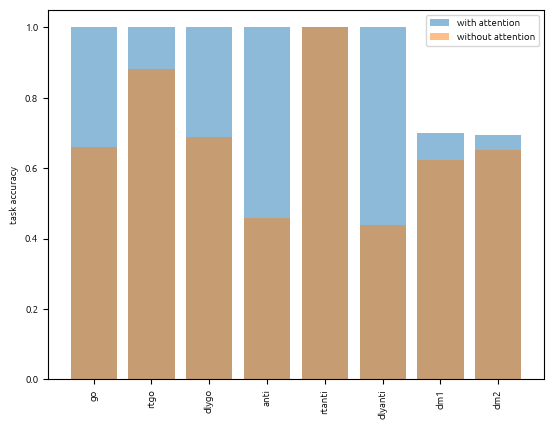

In [5]:
### plot task accuracy
plt.figure()
plt.bar(envs_name,task_accuracy,alpha=0.5)
plt.bar(envs_name,task_accuracy_no_att,alpha=0.5)
plt.legend(['with attention','without attention'])
plt.xticks(rotation=90)
plt.ylabel('task accuracy')
plt.show()

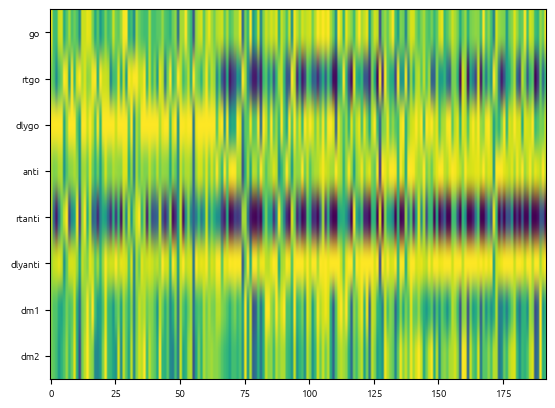

In [6]:
# we use kmean to compute cluster of RNN units
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=16, random_state=0).fit(task_units_variance.T)
cluster_labels = kmeans.labels_

# permute units activity array to have them grouped by cluster
# task_units_variance = task_units_variance[:,np.argsort(cluster_labels)]

plt.figure()
plt.imshow(task_units_variance,aspect='auto')
plt.yticks(np.arange(len(envs_simple)),envs_name)
plt.show()

### PCA analysis

attention matrix (100, 3, 3) max value 0.9995235


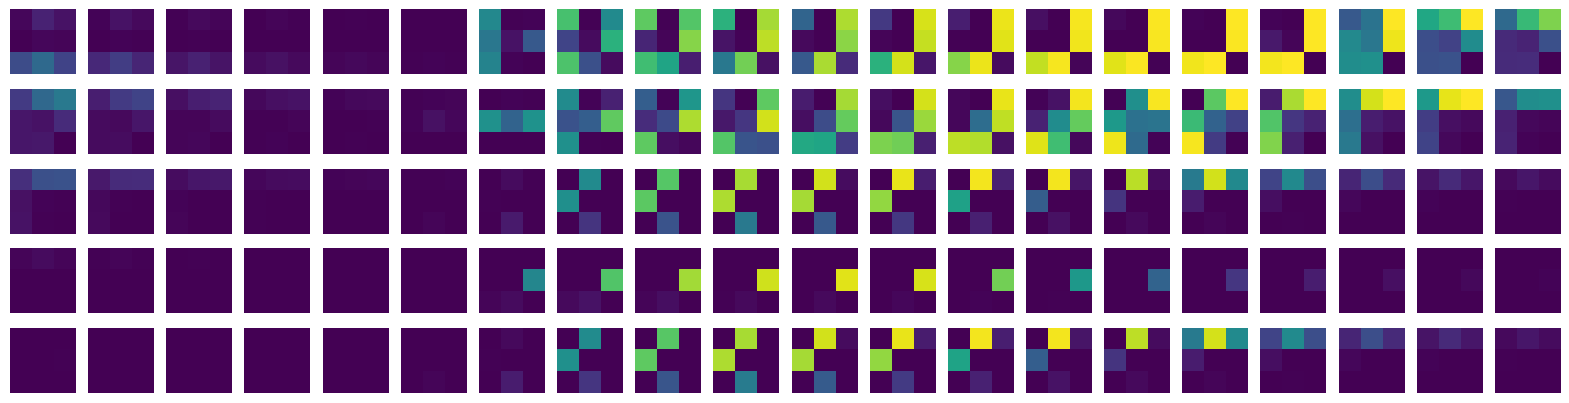

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0  19  39  59  79 100]
(100, 3, 64)


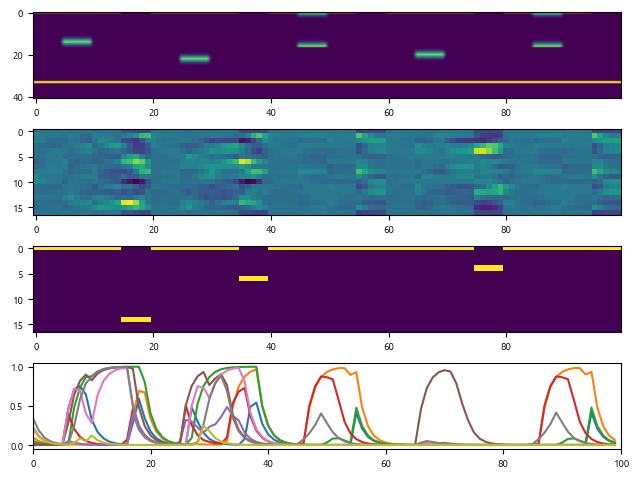

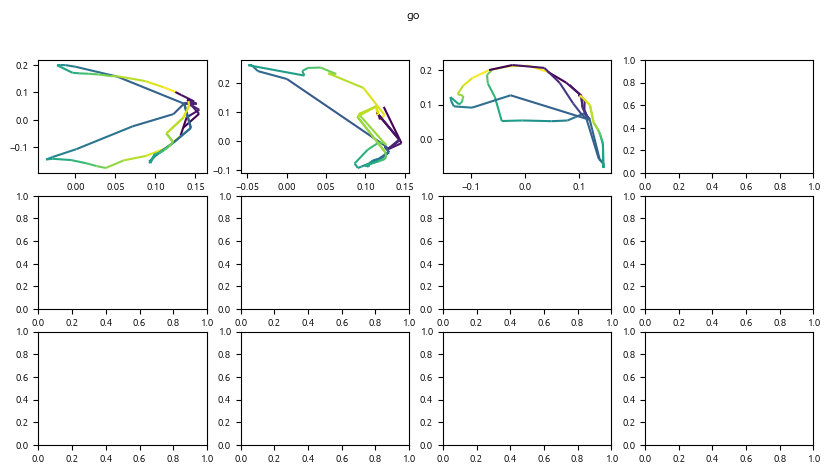

attention matrix (100, 3, 3) max value 0.9698695


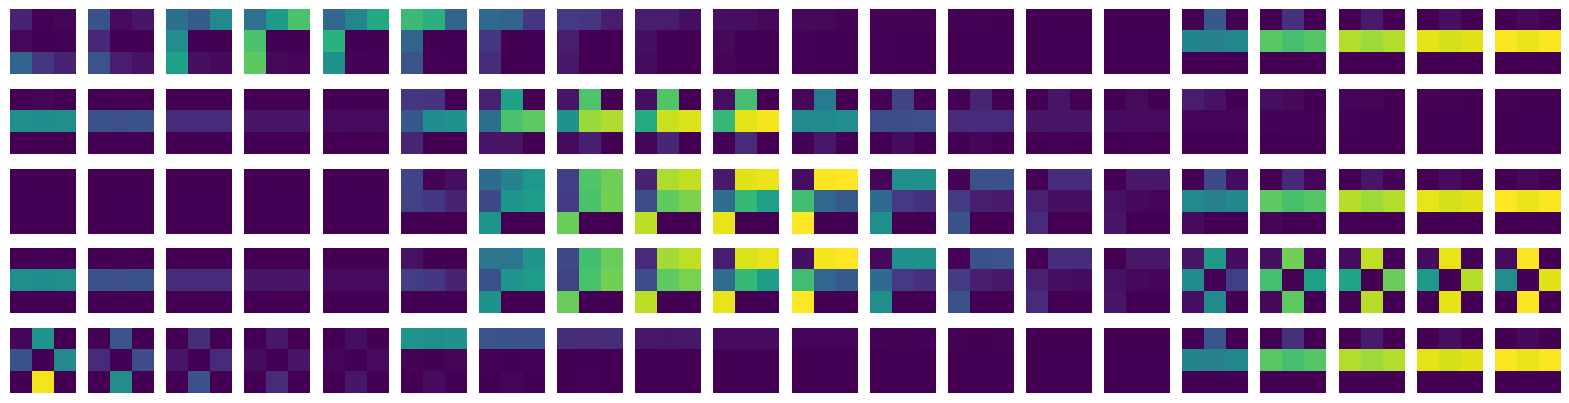

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0   9  19  29  39  49  59  69  79  89 100]
(100, 3, 64)


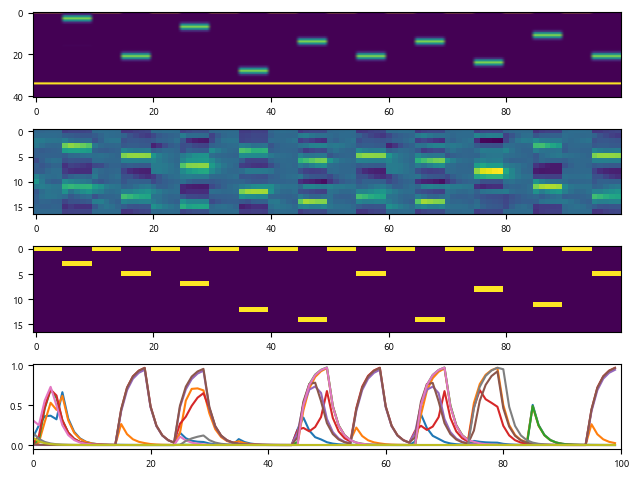

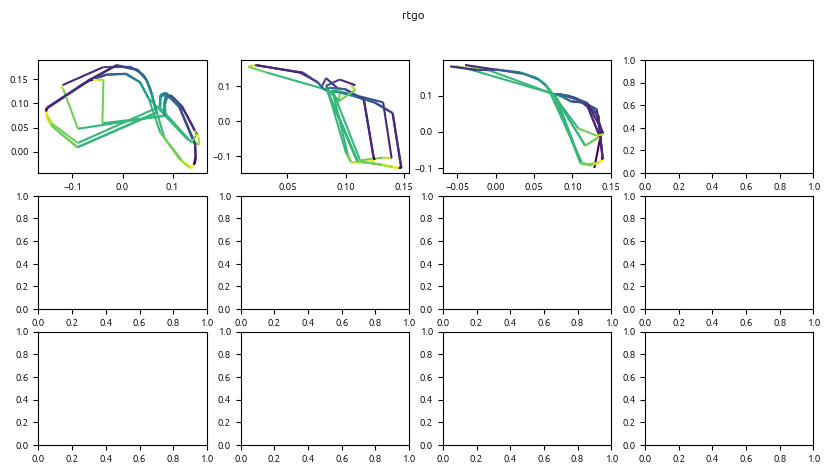

attention matrix (100, 3, 3) max value 0.9997606


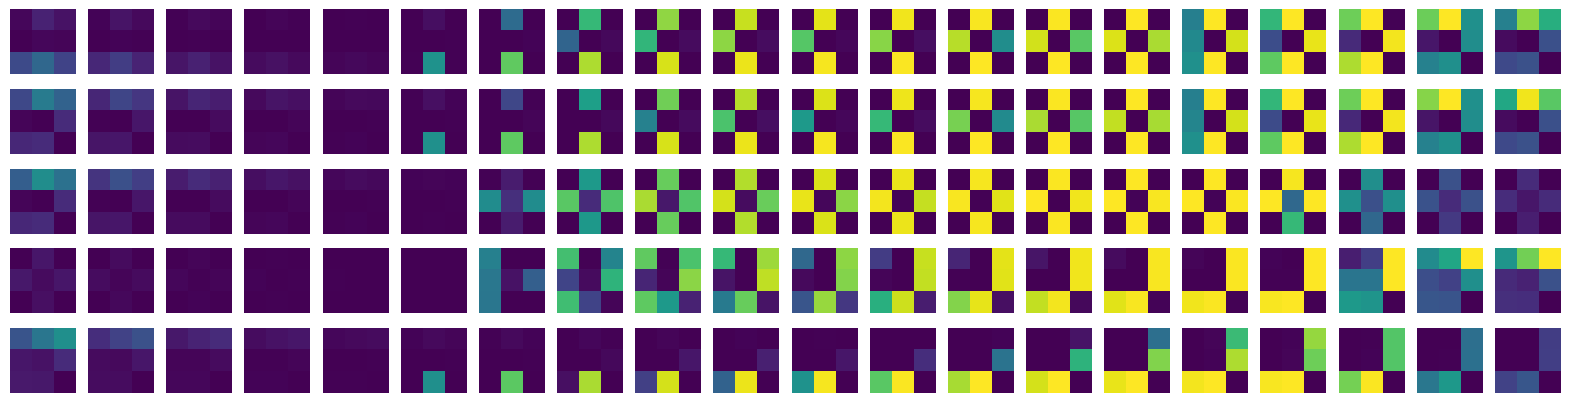

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0  19  39  59  79 100]
(100, 3, 64)


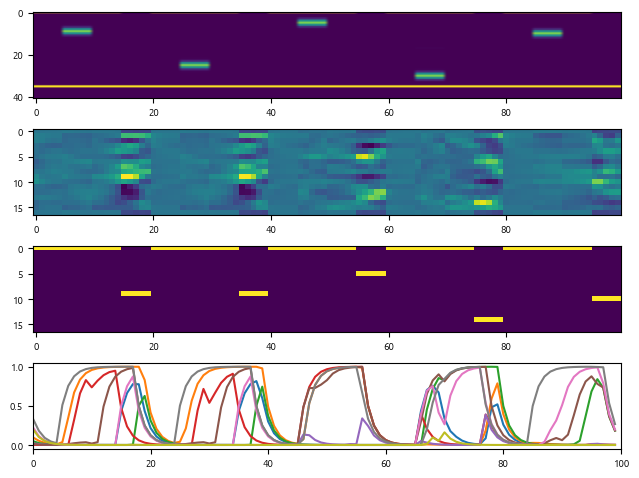

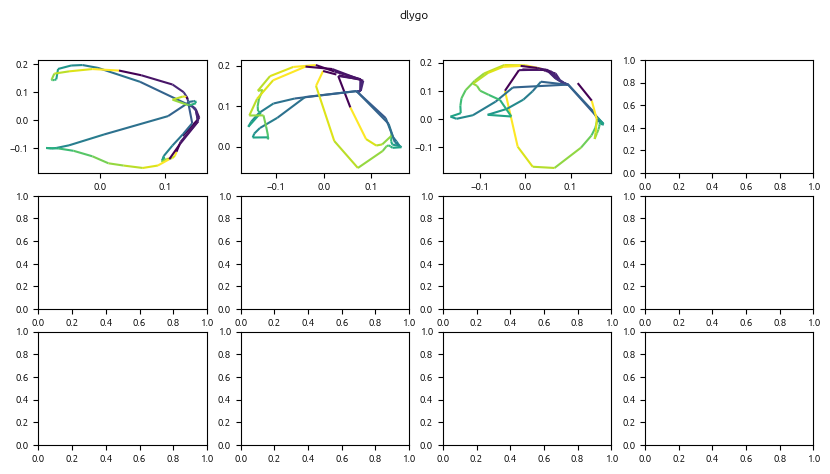

attention matrix (100, 3, 3) max value 0.99986833


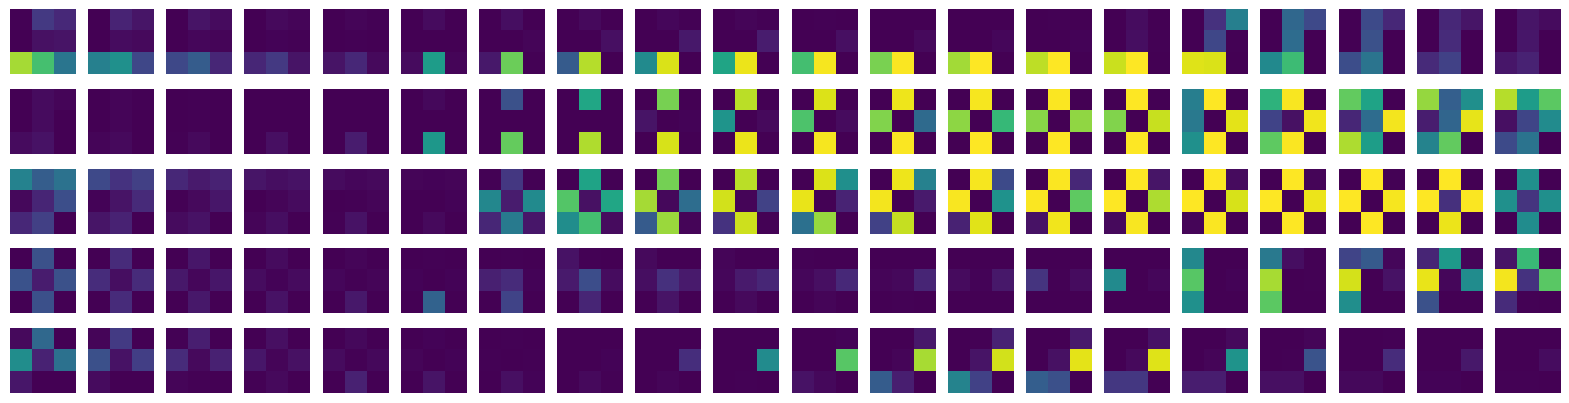

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0  19  39  59  79 100]
(100, 3, 64)


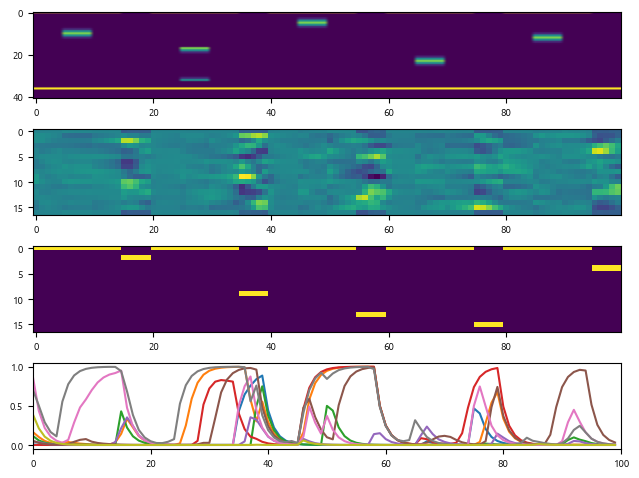

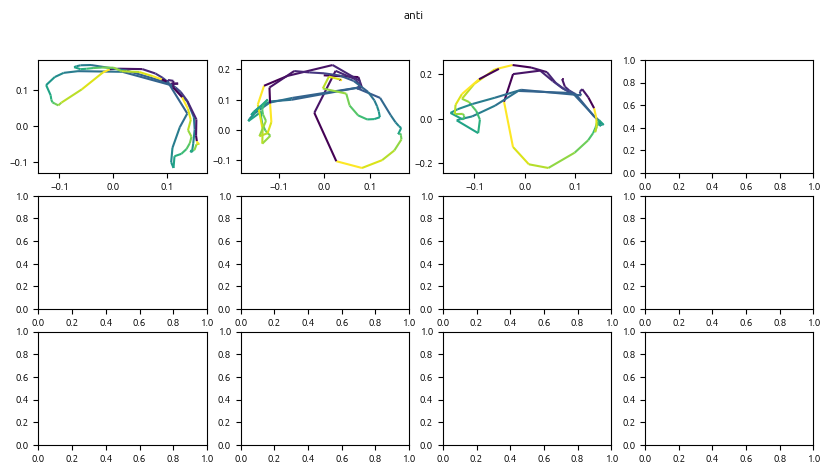

attention matrix (100, 3, 3) max value 0.96906704


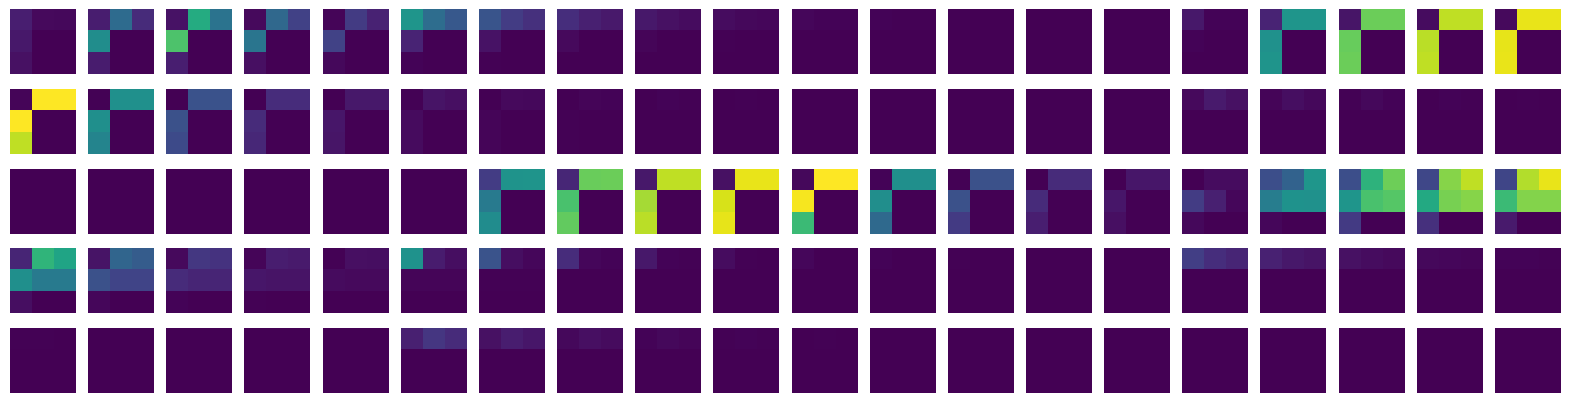

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0   9  19  29  39  49  59  69  79  89 100]
(100, 3, 64)


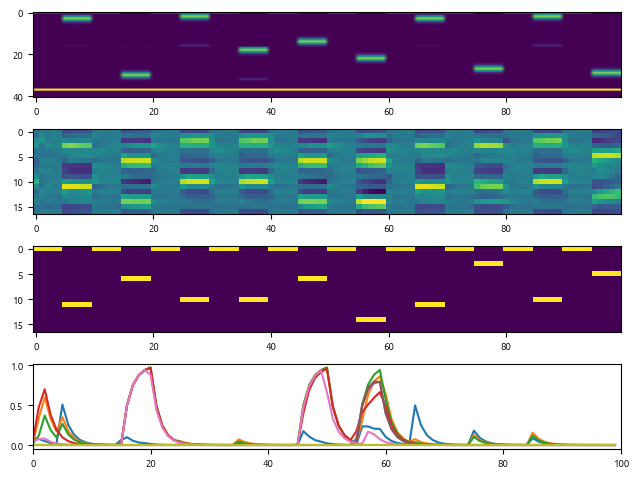

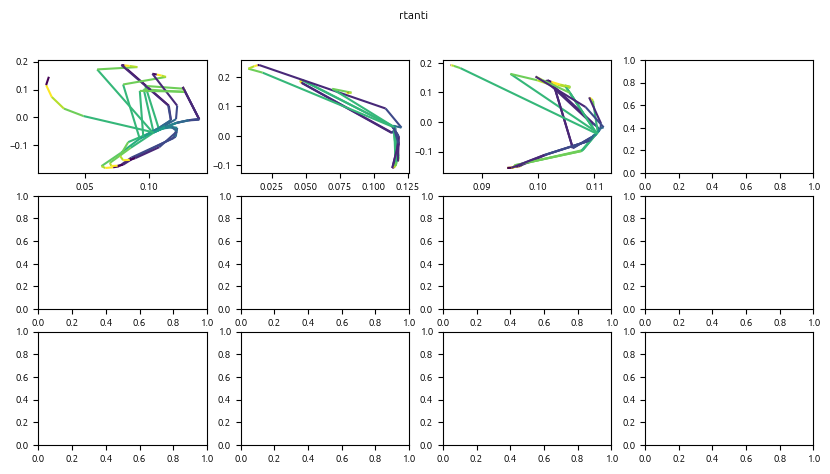

attention matrix (100, 3, 3) max value 0.9995284


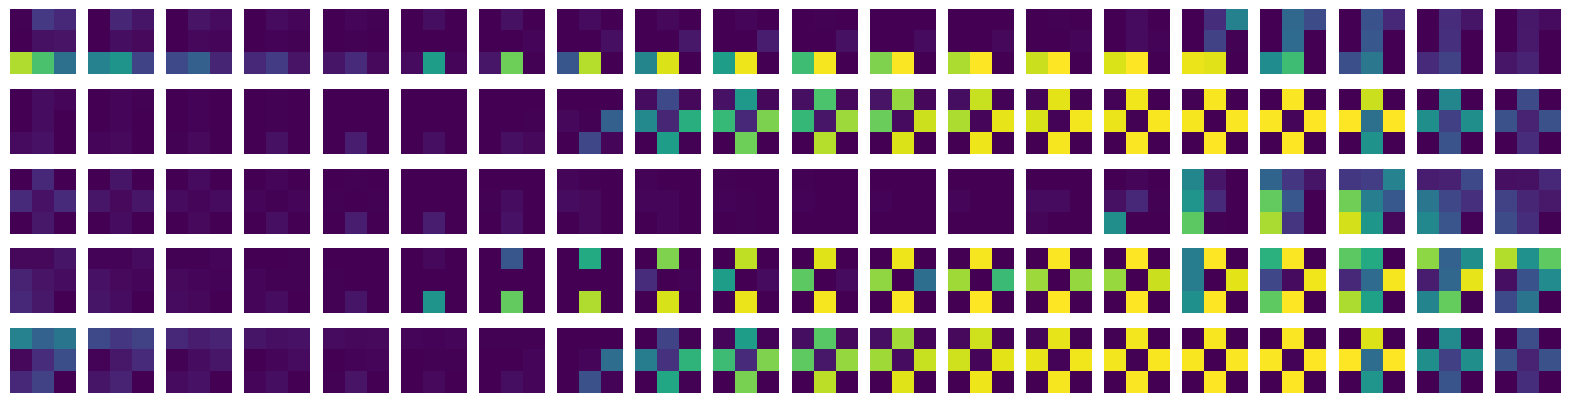

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0  19  39  59  79 100]
(100, 3, 64)


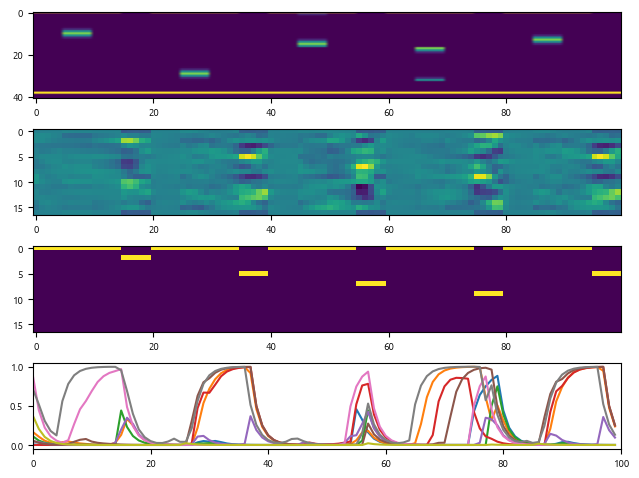

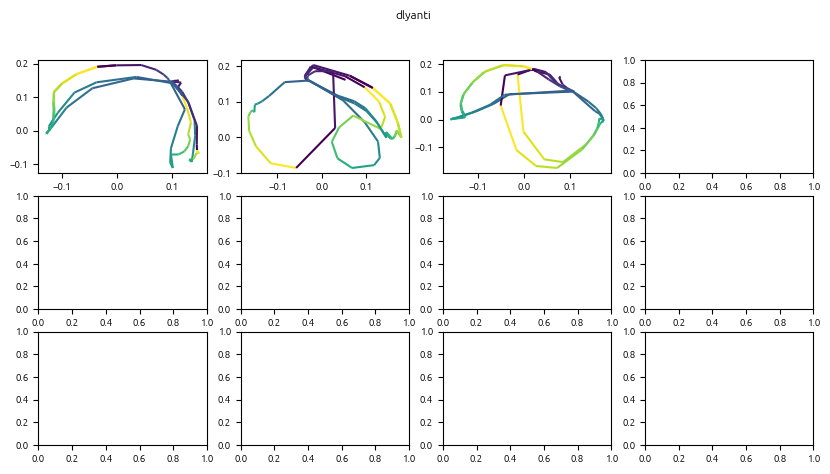

attention matrix (100, 3, 3) max value 0.9713987


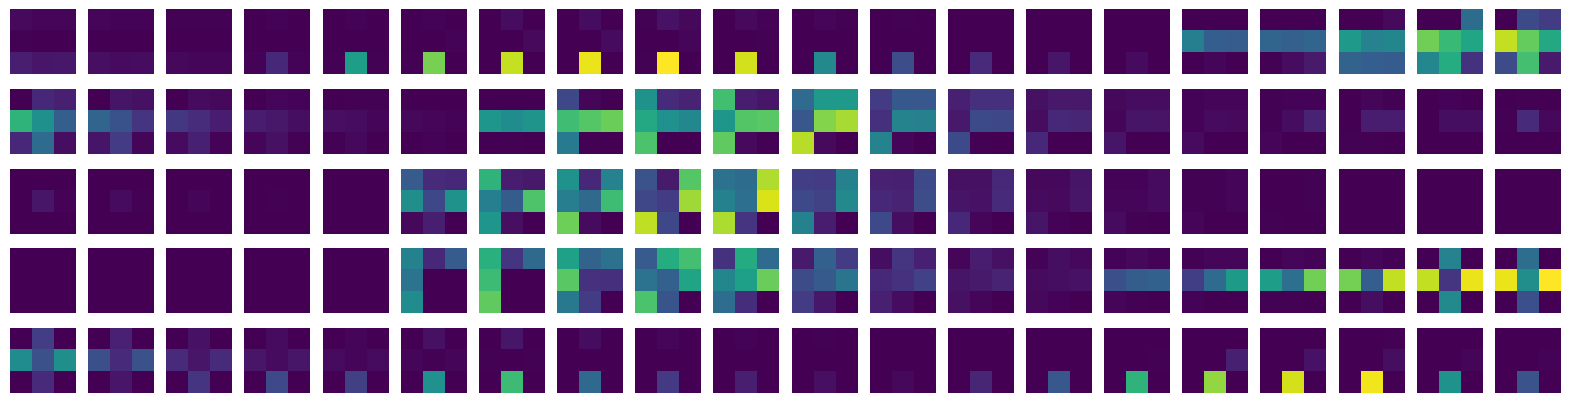

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0   9  20  31  40  49  59  69  79  88  98 100]
(100, 3, 64)


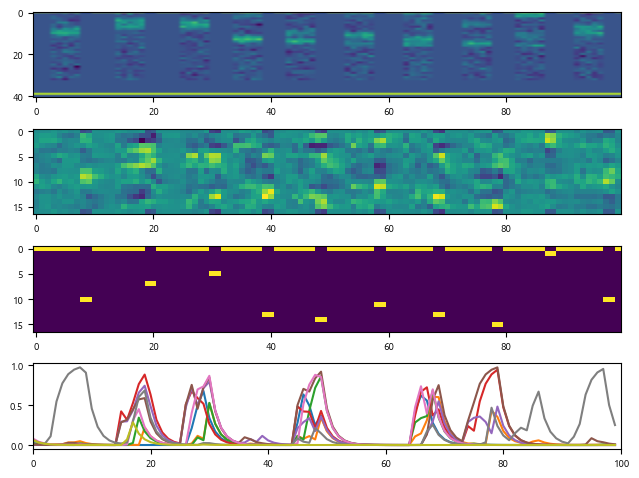

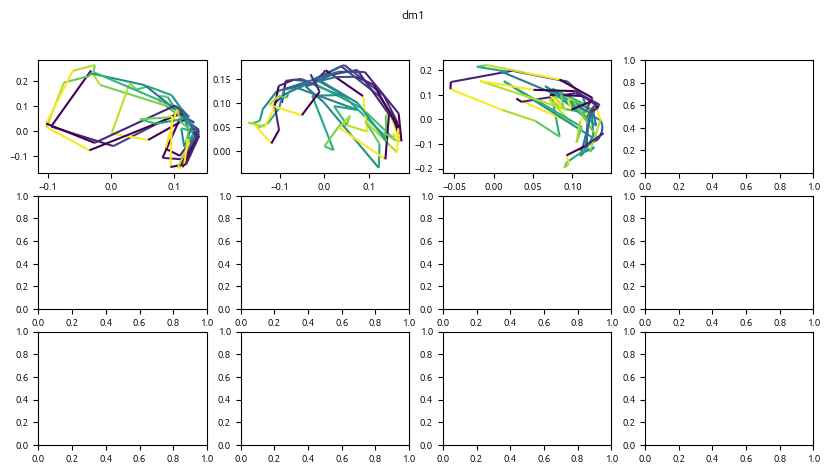

attention matrix (100, 3, 3) max value 0.9921865


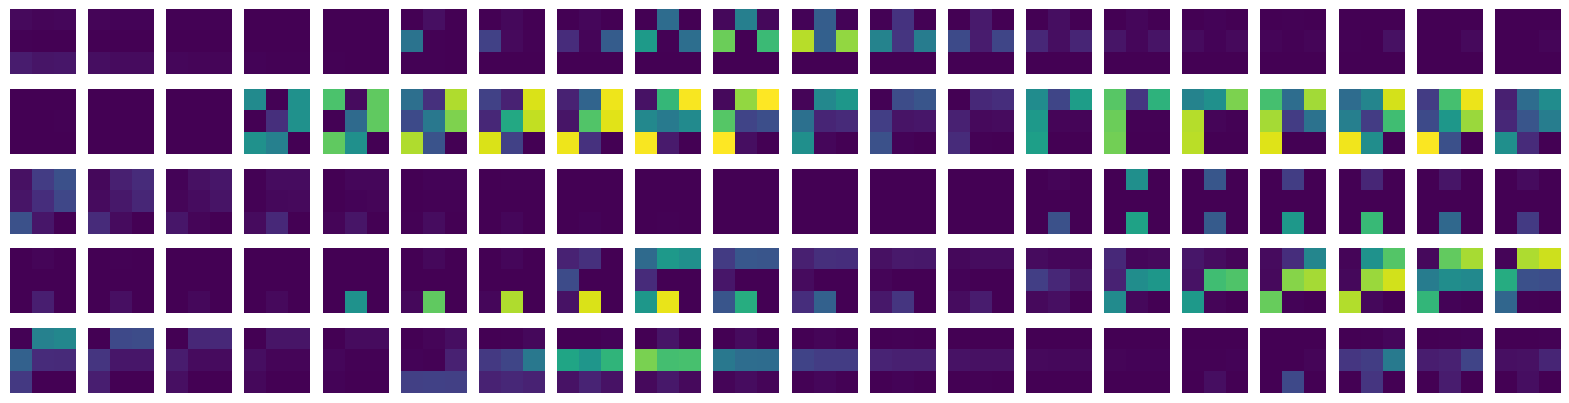

/tmp/ipykernel_523666/1513670635.py:79: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


[  0  10  19  28  38  48  59  69  78  89  98 100]
(100, 3, 64)


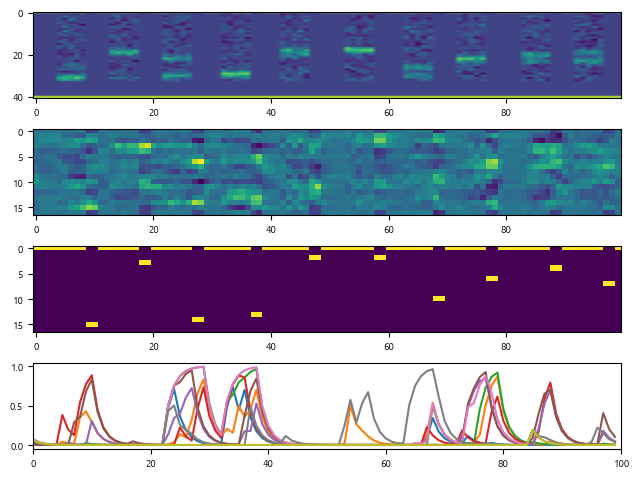

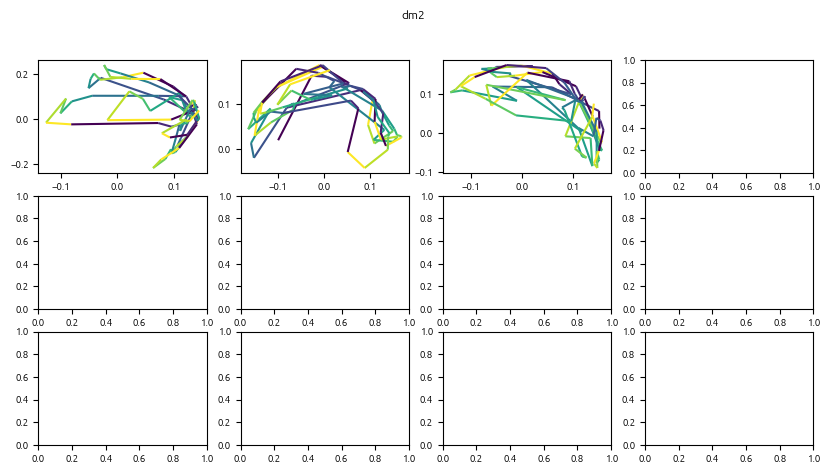

In [7]:
from sklearn.decomposition import PCA
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

'''
envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),
                dm1(), dm2(), ctxdm1(), ctxdm2(), multidm(), dlydm1(), dlydm2(),
                ctxdlydm1(), ctxdlydm2(), multidlydm(), dms(), dnms(), dmc(), dnmc()]

envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti',
                'dm1', 'dm2', 'ctxdm1', 'ctxdm2', 'multidm', 'dlydm1', 'dlydm2',
                'ctxdlydm1', 'ctxdlydm2', 'multidlydm', 'dms', 'dnms', 'dmc', 'dnmc']


'''

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti']

envs_simple = [go(), rtgo(), dlygo(), anti(), rtanti(), dlyanti(),dm1(), dm2()]
envs_name = ['go', 'rtgo', 'dlygo', 'anti', 'rtanti', 'dlyanti','dm1', 'dm2']

batch_size = 1
seq_len = 100

task_units_variance = []
task_accuracy = []

for i,env in enumerate(envs_simple) :


        # iterable dataset from which it is possible to draw samples
        dataset = Dataset(env, batch_size=batch_size, seq_len=seq_len)
        ob_size = env.observation_space.shape[0]
        act_size = env.action_space.n

        # we test for one trajectory
        inputs, labels = dataset()
        inputs = np.transpose(inputs, (1, 0, 2))
        labels = np.transpose(labels, (1, 0))
        targets = np.eye(act_size)[labels]
        
        # we need to add 20 dimensions to the input, corresponding to the task identity
        task_identity = np.zeros((inputs.shape[0],inputs.shape[1],len(envs_simple)))
        task_identity[:,:,i] = 1
        inputs = np.concatenate((inputs,task_identity),axis=2)
        
        outputs_total,hidden_states,_, attn_com, attn_com_rim = model(torch.tensor(inputs,dtype=torch.float).to(device))

        targets = np.eye(act_size)[labels]

        outputs = outputs_total.detach().cpu().numpy()
        
        attn_com_rim =  attn_com_rim.squeeze().detach().cpu().numpy() 

        print("attention matrix",attn_com_rim.shape,"max value",np.max(attn_com_rim))
        min_att = attn_com_rim.min()
        max_att = attn_com_rim.max()
        f,axs = plt.subplots(5,20,figsize=(20,5))
        for k in range(5):
            for j in range(20):
                axs[k,j].imshow(attn_com_rim[k*20+j],vmin=min_att,vmax=max_att)
                # remove axis
                axs[k,j].axis('off')
        plt.show()


        f = plt.figure()
        plt.subplot(411)
        plt.imshow(inputs[:,:,:].T,aspect='auto')
        plt.subplot(412)
        plt.imshow((outputs[:,:,:].T),aspect='auto')
        plt.subplot(413)
        plt.imshow(targets[:,:,:].T,aspect='auto')
        plt.subplot(414)
        plt.plot(attn_com_rim.reshape(seq_len,-1))
        plt.xlim(0,seq_len)
        f.tight_layout()
        f.show()

        # we want to sequence the sequenc into trials by getting index of when the task changes
        task_changes = np.where(np.diff((inputs[0,:,0] > 0)*1) > 0)[0]
        # we add 0 and the last index to the task changes
        task_changes = np.concatenate(([0],task_changes,[len(inputs[0])]))
        print(task_changes)

        # Create color gradient for each trial
        trial_colors = []
        for i_trial in range(len(task_changes)-1):
            trial_length = task_changes[i_trial+1] - task_changes[i_trial]
            gradient = np.linspace(0, 1, trial_length)
            trial_colors.extend(gradient)

        # Choose a colormap (e.g., 'viridis', 'plasma', 'magma', 'inferno')
        cmap = plt.cm.viridis

        # Convert progression values to RGB colors
        colors = cmap(trial_colors)  # Returns RGBA values for each point


        
        hidden_states = np.squeeze(torch.stack(hidden_states).detach().cpu().numpy(),axis=1)
        print(hidden_states.shape)
        hidden_states = hidden_states[task_changes[1]:,:,:]

        # we remove the first trial
        
        # hidden_states = hidden_states.reshape(seq_len,-1)
        
        # for every module we would like to see the pca space of the hidden states
        f,axs = plt.subplots(3,4,figsize=(10,5))
        for i_mech in range(hidden_states.shape[1]) :
            hidden_states_mech = hidden_states[:,i_mech,:]
            hidden_states_mech = hidden_states_mech.T
            pca = PCA(n_components=2)
            pca.fit(hidden_states_mech)
            ax = axs[i_mech//4,i_mech%4]
            # ax.scatter(pca.components_[0,:],pca.components_[1,:],c=colors)
            points = np.column_stack((pca.components_[0,:], pca.components_[1,:]))
            segments = np.array([points[i:i+2] for i in range(len(points)-1)])
            lc = LineCollection(segments, cmap='viridis', array=trial_colors[:-1])
            ax.add_collection(lc)
            ax.autoscale()
        f.suptitle(envs_name[i])
        plt.show()

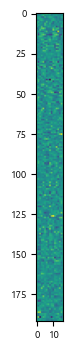

In [9]:
plt.figure(figsize=(20,4))
plt.imshow(model.output_layer.weight.detach().cpu().numpy().T)
plt.show()